In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))
from numpy import array
from numpy import asarray
from numpy import zeros
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

In [ ]:
dataTrain = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis Project final/Tweets_train.csv")
print(dataTrain.head())
dataValidate = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis Project final/Tweets_dev.csv")
print(dataValidate.shape)

             tweet_id                                               text  \
0  569179849518161920                    @united you're good. Thank you!   
1  569835751275433984  @AmericanAir way to ruin a vacation, my brothe...   
2  568588936852799488  @JetBlue yes thankfully! Catering just got her...   
3  569525116725567491  @USAirways The automated message isn't helpful...   
4  568807823187976193  @JetBlue I'm #MakingLoveOutofNothingAtAll on m...   

  airline_sentiment  
0          positive  
1          negative  
2          positive  
3          negative  
4          positive  
(1318, 3)


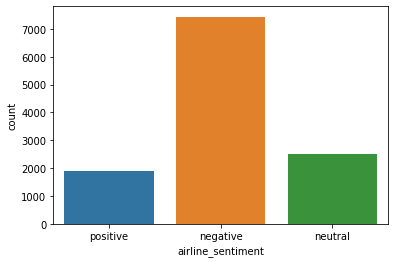

In [ ]:
import seaborn as sns
sns.countplot(x='airline_sentiment', data = dataTrain)

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub(' ',text)

In [ ]:
def preprocessing(sentence):
    statement = sentence.lower()
    statement = remove_tags(statement)
    statement = re.sub('[^a-zA-Z]',' ',statement)
    statement = re.sub(r'\s+[a-zA-Z]\s',' ',statement)
    statement = re.sub(r'\s+', ' ', statement)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
    statement = pattern.sub('', statement) 
    return statement

In [ ]:
corpus_Train = []
sentences = list(dataTrain['text'])
for x in sentences:
    corpus_Train.append(preprocessing(x))
corpus_Train

[' united good thank ',
 ' americanair way ruin vacation brother called night multiple places line get dead air call back',
 ' jetblue yes thankfully catering got loading frustrated supposed ',
 ' usairways automated message helpful impossible speak human right desperately need luggage ',
 ' jetblue makingloveoutofnothingatall brandloveaffair lax https co kdhruf sw',
 ' americanair downloaded app iphone notice drink coupon nothing displayed getting ready fly ',
 ' united post link article verifies initial complaint comments saying thing harris',
 ' jetblue sure anything help great ',
 ' americanair baggage lost flight cancelled flightled get accommodations even another airline least one free hotel ',
 ' usairways charlotte staff needs prayer disappointed response mishaps lotttttttt pissed people ',
 ' usairways suggest failures make huge donation uso charlotte nc provided great customer service today unlike ',
 ' americanair please explain costs almost price full roundtrip fair change 

In [ ]:
corpus_Dev = []
sentences = list(dataValidate['text'])
for x in sentences:
    corpus_Dev.append(preprocessing(x))
type(corpus_Dev)

list

In [ ]:
sentiment_Train = dataTrain['airline_sentiment']
sentiment_Train = np.array(list(map(lambda x:1 if x== "positive" else (0 if x == "negative" else 2), sentiment_Train)))
print(type(sentiment_Train))

<class 'numpy.ndarray'>


In [ ]:
sentiment_validate = dataValidate['airline_sentiment']
sentiment_validate = np.array(list(map(lambda x:1 if x== "positive" else (0 if x == "negative" else 2), sentiment_validate)))
print(type(sentiment_validate))

<class 'numpy.ndarray'>


In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(corpus_Train)
word_tokenizer.fit_on_texts(corpus_Dev)

In [ ]:
X_train = word_tokenizer.texts_to_sequences(corpus_Train)
X_dev = word_tokenizer.texts_to_sequences(corpus_Dev)

In [ ]:
vocab_length = len(word_tokenizer.word_index) +1
print(vocab_length)

12759


In [ ]:
max_len = 1100
X_train = pad_sequences(X_train,padding = 'post', maxlen =max_len)
X_dev = pad_sequences(X_dev,padding = 'post', maxlen =max_len)
print(type(X_train))

<class 'numpy.ndarray'>


In [ ]:
embeddings_dictonary = dict()
glove_file = open('/content/drive/MyDrive/Sentiment Analysis Project final/a2_glove.6B.100d.txt',encoding = "utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype ='float32')
    embeddings_dictonary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_length,100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictonary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
print(embedding_matrix.shape)


(12759, 100)


In [ ]:
cnn = Sequential()
embedding_layer = Embedding(vocab_length,100,weights = [embedding_matrix], input_length=max_len , trainable=False)
cnn.add(embedding_layer)

cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn.summary())
cnn_history = cnn.fit(X_train, sentiment_Train, batch_size=128, epochs=6, verbose=1)
score = cnn.evaluate(X_dev,sentiment_validate, verbose=1)
print("Score is", score[0])
print("Accuracy is:", score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1100, 100)         1275900   
                                                                 
 conv1d (Conv1D)             (None, 1096, 128)         64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,340,157
Trainable params: 64,257
Non-trainable params: 1,275,900
_________________________________________________________________
None
Epoch 1/6
93/93 [==============================] - 53s 564ms/step - loss: 0.2272 - acc: 0.5096
Epoch 2

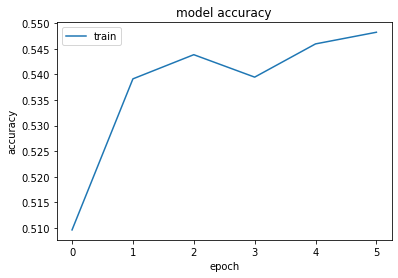

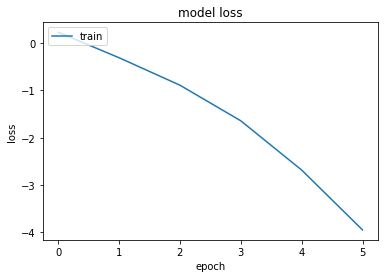

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['acc'])


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_history.history['loss'])


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()